# Forecasting with machine learning

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

2023-02-26 10:54:06.323156: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

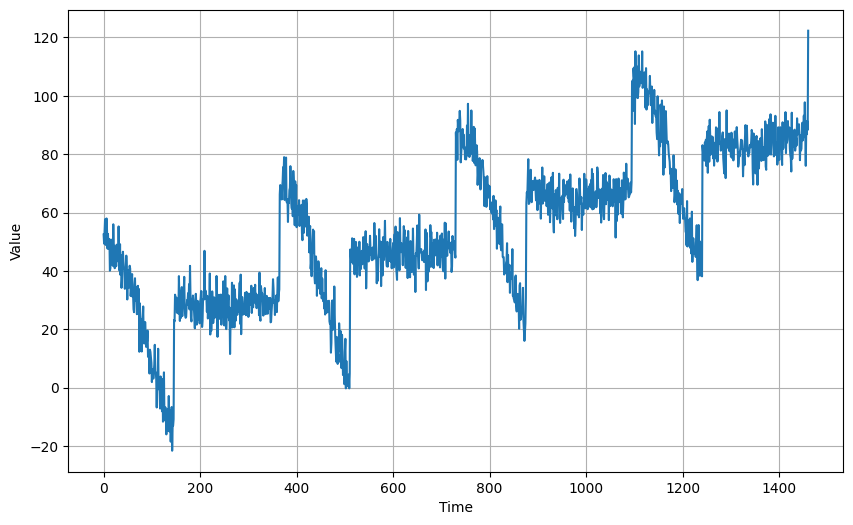

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Forecasting with Machine Learning

First, we will train a model to forecast the next step given the previous 30 steps, therefore, we need to create a dataset of 30-step windows for training.

In [4]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

### Linear Model

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs = 100, validation_data=valid_set)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-02-22 17:08:14.635560: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
31/31 [==============================] - 3s 55ms/step - loss: 408.1605 - mae: 408.6602 - val_loss: 800.5363 - val_mae: 801.0363
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 381.1479 - mae: 381.6475 - val_loss: 1436.4420 - val_mae: 1436.9420
Epoch 3/100
31/31 [==============================] - 1s 12ms/step - loss: 634.8313 - mae: 635.3311 - val_loss: 876.6884 - val_mae: 877.1884
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 618.1973 - mae: 618.6973 - val_loss: 447.0239 - val_mae: 447.5239
Epoch 5/100
31/31 [==============================] - 1s 10ms/step - loss: 774.7850 - mae: 775.2850 - val_loss: 2748.1311 - val_mae: 2748.6311
Epoch 6/100
31/31 [==============================] - 0s 7ms/step - loss: 724.9752 - mae: 725.4747 - val_loss: 40.0006 - val_mae: 40.4987
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 403.5472 - mae: 404.0471 - val_loss: 343.8951 - val_mae: 344.3951
Epoch 8/100
31/31 [===

In [36]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 131.0524 - mae: 131.5521 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 115.4794 - mae: 115.9790 - lr: 1.0798e-06
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 97.1274 - mae: 97.6264 - lr: 1.1659e-06
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 77.3875 - mae: 77.8875 - lr: 1.2589e-06
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 56.2189 - mae: 56.7186 - lr: 1.3594e-06
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 33.5727 - mae: 34.0713 - lr: 1.4678e-06
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 12.4484 - mae: 12.9418 - lr: 1.5849e-06
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 7.2724 - mae: 7.7561 - lr: 1.7113e-06
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 7.1769 - mae: 7.6620 

## Train and plot the mechanized model

In [38]:
import sys
sys.path.append("..")

from mechanism.mechanized_sequential import MechanizedSequential
from mechanism.mechanized_sequential import Mechanism



In [43]:
train_set = window_dataset(x_train, window_size)


gaussian_model = MechanizedSequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
gaussian_model.choose_mech(Mechanism.GAUSSIAN)
gaussian_model.set_gaussian_para(0, 0.05)

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)


gaussian_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
gaussian_history = gaussian_model.fit(train_set, epochs = 100, callbacks=[lr_schedule])

Epoch 1/100
In Gaussian Mechanism
In Gaussian Mechanism
31/31 [==============================] - 1s 3ms/step - loss: 49.4290 - mae: 49.9302 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 34.8777 - mae: 35.3770 - lr: 1.0798e-06
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 19.2371 - mae: 19.7331 - lr: 1.1659e-06
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 9.4498 - mae: 9.9381 - lr: 1.2589e-06
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 8.6413 - mae: 9.1253 - lr: 1.3594e-06
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 8.5585 - mae: 9.0453 - lr: 1.4678e-06
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 8.5045 - mae: 8.9925 - lr: 1.5849e-06
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 8.4307 - mae: 8.9151 - lr: 1.7113e-06
Epoch 9/100
31/31 [==============================] - 0s 2ms/st

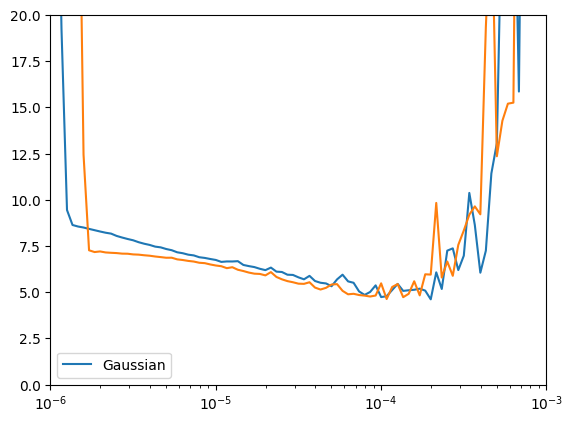

In [44]:
plt.semilogx(gaussian_history.history["lr"], gaussian_history.history["loss"], label = "Gaussian")
plt.axis([1e-6, 1e-3, 0, 20])
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])
plt.legend()

In [9]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 2s 19ms/step - loss: 660.1274 - mae: 660.6274 - val_loss: 2174.7410 - val_mae: 2175.2410
Epoch 2/500
31/31 [==============================] - 0s 8ms/step - loss: 648.8583 - mae: 649.3578 - val_loss: 248.7473 - val_mae: 249.2473
Epoch 3/500
31/31 [==============================] - 0s 6ms/step - loss: 324.7164 - mae: 325.2163 - val_loss: 961.4354 - val_mae: 961.9354
Epoch 4/500
31/31 [==============================] - 0s 8ms/step - loss: 335.6037 - mae: 336.1033 - val_loss: 876.5536 - val_mae: 877.0536
Epoch 5/500
31/31 [==============================] - 0s 6ms/step - loss: 516.3419 - mae: 516.8418 - val_loss: 48.5179 - val_mae: 49.0170
Epoch 6/500
31/31 [==============================] - 0s 6ms/step - loss: 368.9164 - mae: 369.4162 - val_loss: 2759.3098 - val_mae: 2759.8098
Epoch 7/500
31/31 [==============================] - 0s 6ms/step - loss: 391.9165 - mae: 392.4163 - val_loss: 659.5459 - val_mae: 660.0459
Epoch 8/500
31/31 [=====

In [45]:
gaussian_model = MechanizedSequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
gaussian_model.choose_mech(Mechanism.GAUSSIAN)
gaussian_model.set_gaussian_para(0, 0.1)

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
gaussian_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
gaussian_model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
In Gaussian Mechanism
In Gaussian Mechanism
     20/Unknown - 1s 3ms/step - loss: 596.4913 - mae: 596.9878In Gaussian Mechanism
31/31 [==============================] - 2s 21ms/step - loss: 492.7600 - mae: 493.2606 - val_loss: 243.9747 - val_mae: 244.4755
Epoch 2/500
31/31 [==============================] - 0s 7ms/step - loss: 234.9446 - mae: 235.4453 - val_loss: 421.8832 - val_mae: 422.3886
Epoch 3/500
31/31 [==============================] - 0s 7ms/step - loss: 468.0909 - mae: 468.5865 - val_loss: 1242.7228 - val_mae: 1243.2242
Epoch 4/500
31/31 [==============================] - 0s 7ms/step - loss: 868.6619 - mae: 869.1693 - val_loss: 2285.7349 - val_mae: 2286.2390
Epoch 5/500
31/31 [==============================] - 1s 11ms/step - loss: 905.3458 - mae: 905.8477 - val_loss: 850.0599 - val_mae: 850.5613
Epoch 6/500
31/31 [==============================] - 0s 7ms/step - loss: 240.2354 - mae: 240.7362 - val_loss: 1208.8667 - val_mae: 1209.3700
Epoch 7/500
31/31 [===========

In [10]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [11]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

15/15 [==============================] - 0s 6ms/step


In [46]:
gaussian_lin_forecast = model_forecast(gaussian_model, series[split_time - window_size:-1], window_size)[:, 0]

15/15 [==============================] - 0s 5ms/step


In [49]:
lin_forecast.shape

gaussian_lin_forecast.shape

(461,)

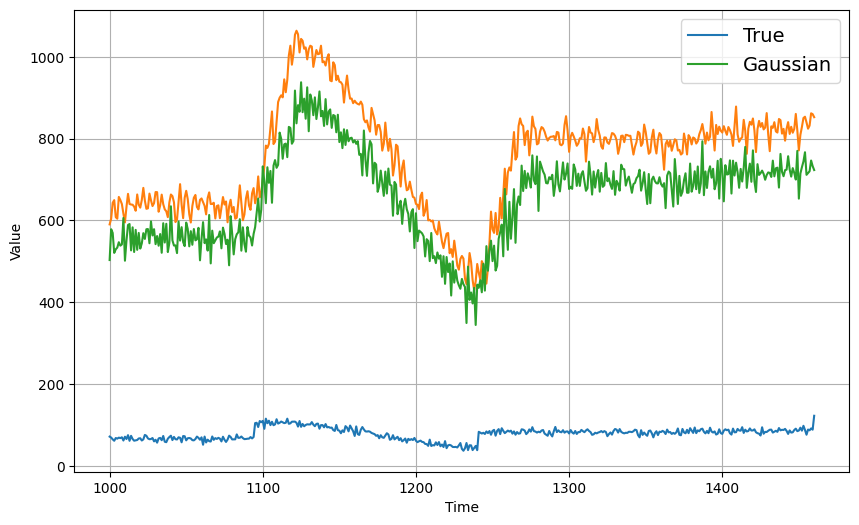

In [52]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label = "True")

plot_series(time_valid, lin_forecast)

plot_series(time_valid, gaussian_lin_forecast, label = "Gaussian")

In [14]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

675.2725

In [53]:
keras.metrics.mean_absolute_error(x_valid, gaussian_lin_forecast).numpy()

579.3645

### Dense Model Forecasting

In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 44.3705 - mae: 44.8705 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 43.8595 - mae: 44.3595 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 43.2375 - mae: 43.7374 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 42.5437 - mae: 43.0435 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 41.7682 - mae: 42.2678 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 40.9020 - mae: 41.4019 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 39.9439 - mae: 40.4438 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 38.8827 - mae: 39.3826 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 37.7365 - mae: 38.2363 

# Dense mechanized model forecasting

In [ ]:
gaussian_model = MechanizedSequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

gaussian_model.choose_mech(Mechanism.GAUSSIAN)
gaussian_model.set_gaussian_para(0, 0.1)

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
gaussian_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
gaussian_history = gaussian_model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 44.3705 - mae: 44.8705 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 43.8595 - mae: 44.3595 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 43.2375 - mae: 43.7374 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 42.5437 - mae: 43.0435 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 41.7682 - mae: 42.2678 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 40.9020 - mae: 41.4019 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 39.9439 - mae: 40.4438 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 38.8827 - mae: 39.3826 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 37.7365 - mae: 38.2363 

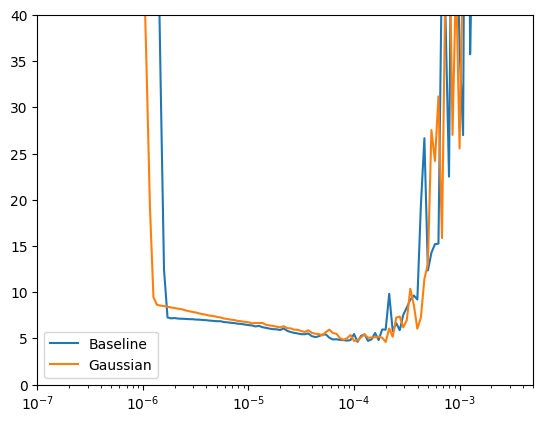

In [56]:
plt.semilogx(history.history["lr"], history.history["loss"], label = "Baseline")
# plt.axis([1e-7, 5e-3, 0, 30])

plt.semilogx(gaussian_history.history["lr"], gaussian_history.history["loss"], label = "Gaussian")
plt.axis([1e-7, 5e-3, 0, 40])

plt.legend()


In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 2s 18ms/step - loss: 56.4141 - mae: 56.9125 - val_loss: 65.1113 - val_mae: 65.6113
Epoch 2/500
31/31 [==============================] - 0s 6ms/step - loss: 18.7990 - mae: 19.2931 - val_loss: 39.3010 - val_mae: 39.8010
Epoch 3/500
31/31 [==============================] - 0s 6ms/step - loss: 15.7811 - mae: 16.2747 - val_loss: 33.9180 - val_mae: 34.4172
Epoch 4/500
31/31 [==============================] - 0s 6ms/step - loss: 27.1067 - mae: 27.6037 - val_loss: 39.6784 - val_mae: 40.1784
Epoch 5/500
31/31 [==============================] - 0s 7ms/step - loss: 15.4090 - mae: 15.8999 - val_loss: 35.6001 - val_mae: 36.0985
Epoch 6/500
31/31 [==============================] - 0s 6ms/step - loss: 15.6503 - mae: 16.1427 - val_loss: 34.0230 - val_mae: 34.5220
Epoch 7/500
31/31 [==============================] - 0s 10ms/step - loss: 15.7322 - mae: 16.2256 - val_loss: 33.6370 - val_mae: 34.1363
Epoch 8/500
31/31 [==============================] - 

# Mechanized dense forecast

In [57]:
gaussian_model = MechanizedSequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

gaussian_model.choose_mech(Mechanism.GAUSSIAN)
gaussian_model.set_gaussian_para(0, 0.1)

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
gaussian_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
gaussian_model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
In Gaussian Mechanism
In Gaussian Mechanism
     27/Unknown - 2s 2ms/step - loss: 109.5525 - mae: 110.0487In Gaussian Mechanism
31/31 [==============================] - 2s 17ms/step - loss: 102.1021 - mae: 102.5988 - val_loss: 76.9677 - val_mae: 77.4684
Epoch 2/500
31/31 [==============================] - 1s 12ms/step - loss: 39.7296 - mae: 40.2287 - val_loss: 74.1337 - val_mae: 74.6390
Epoch 3/500
31/31 [==============================] - 0s 6ms/step - loss: 37.1463 - mae: 37.6484 - val_loss: 71.3638 - val_mae: 71.8654
Epoch 4/500
31/31 [==============================] - 0s 6ms/step - loss: 34.7041 - mae: 35.2091 - val_loss: 68.6552 - val_mae: 69.1595
Epoch 5/500
31/31 [==============================] - 0s 8ms/step - loss: 32.2949 - mae: 32.7955 - val_loss: 65.9447 - val_mae: 66.4460
Epoch 6/500
31/31 [==============================] - 0s 6ms/step - loss: 29.8487 - mae: 30.3413 - val_loss: 63.2820 - val_mae: 63.7790
Epoch 7/500
31/31 [==============================] - 0s 7m

In [58]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

gaussian_dense_forecast = model_forecast(
    gaussian_model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 [==============================] - 0s 7ms/step


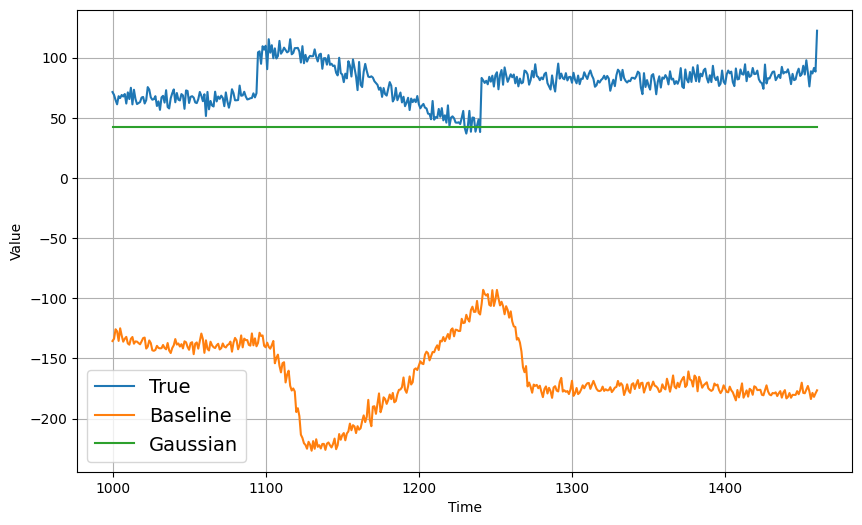

In [59]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label = "True")
plot_series(time_valid, dense_forecast, label = "Baseline")

plot_series(time_valid, gaussian_dense_forecast, label = "Gaussian")

In [62]:
print(keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy())

print(keras.metrics.mean_absolute_error(x_valid, gaussian_dense_forecast).numpy())

241.02808
36.13963
